# Train Simulator

Requires fitting three models:
+ a user choice model
+ a single or set of recommender models
+ a user visit model

In [1]:
import paths
%cd {paths.base}
from os.path import join

%load_ext autoreload
%autoreload 2
from simtrain import process_dat, sim_models, explore_models, utils
from simtrain import SETTINGS_POLIMI as SETTINGS
import numpy as np
import pandas as pd
%matplotlib inline
from matplotlib import pyplot as plt
import scipy
from scipy import stats, sparse
import shutil
from datetime import datetime
import os
os.environ['NUMEXPR_MAX_THREADS'] = SETTINGS.NUMEXPR_MAX_THREADS

/root/notebooks/accordion
loaded sim_models


In [2]:
print(SETTINGS.simulation_components)
ab_test_id = SETTINGS.simulation_components['ab_test_id']
input_data_path = join(paths.dat, SETTINGS.rootpaths['input'])
full_data_path = join(input_data_path, SETTINGS.filepaths['impressions_data_test']) % ab_test_id
subset_data_path = full_data_path + '_subset'

cell_col = 'acnt.test_cell_nbr'
cells = {'train':1,
        'valid':2,
        'test_seen_users':3,
        'test_unseen_users':4}

{'ab_test_id': 'train', 'rec_model_cell_nbr': [1], 'user_model_cell_nbr': 1, 'visit_model_cell_nbr': 1}


In [3]:
train_dat, stg = process_dat.load_dat(paths.cw_stages['output']['train'])
print('settings',stg)
train_dat

settings {'NI': 920, 'NU': 1649, 'T': 69.97971343994139, 'NS': 100, 'INF_TIME': 1000}


,Unnamed: 0,user_id,time,action,state,rec_id,reward,round_time
0,13630,535,12.156898,434,,1,0.0,12.166667
1,13631,535,12.156898,789,,0,0.0,12.166667
2,13632,535,12.156898,789,,0,0.0,12.166667
3,13633,535,12.156898,407,,0,0.0,12.166667
4,13634,535,12.156898,407,,1,0.0,12.166667
...,...,...,...,...,...,...,...,...
8594953,31540,41536,64.452988,870,773:773:773:773:373:773,0,0.0,64.458333
8594954,31541,41536,64.452988,309,773:773:773:773:373:773,0,0.0,64.458333
8594955,31542,41536,64.452988,442,773:773:773:773:373:773,0,0.0,64.458333
8594956,31543,41536,64.452988,616,773:773:773:773:373:773,0,0.0,64.458333


In [4]:
validation_dat, _ = process_dat.load_dat(paths.cw_stages['output']['validate'])
test_seen_users_dat, _ = process_dat.load_dat(paths.cw_stages['output']['test-seen'])
test_unseen_users_dat, _ = process_dat.load_dat(paths.cw_stages['output']['test-unseen'])

In [5]:
# combine all into one dataframe with new column indicating "cell", i.e. train = 1, validate = 2, test seen = 3, test unseen = 4
train_dat[cell_col] = cells['train']
validation_dat[cell_col] = cells['valid']
test_seen_users_dat[cell_col] = cells['test_seen_users']
test_unseen_users_dat[cell_col] = cells['test_unseen_users']
all_dat = pd.concat([train_dat, validation_dat, test_seen_users_dat, test_unseen_users_dat], ignore_index = True)
simulation = all_dat

In [6]:
# finally calculate settings dict from all data:
stg = process_dat.get_settings(all_dat)
print('settings',stg)

settings {'NI': 920, 'NU': 2405, 'T': 97.99787902832031, 'NS': 100, 'INF_TIME': 1000}


In [7]:
print('summary stats of data splits:')
for i in range(1,5):
    print('cell %i:' % i, all_dat[all_dat['acnt.test_cell_nbr']==i].time.count(), 'impressions')

summary stats of data splits:
cell 1: 8594958 impressions
cell 2: 4047541 impressions
cell 3: 2382171 impressions
cell 4: 1033310 impressions


In [8]:
# num users in each cell
for i in range(1,5):
    print('num users in cell %i:' % i,simulation[simulation['acnt.test_cell_nbr']==i].user_id.nunique())

num users in cell 1: 1649
num users in cell 2: 698
num users in cell 3: 1247
num users in cell 4: 534


In [9]:
# create subset of data for hyperparameter selection:
np.random.seed(87)
hyp_sub_sim = simulation.sample(n=10000000)

In [3]:
intermediate_path = paths.cw_stages['output']['alldat']
hyp_subset_path = paths.cw_stages['output']['hypsubset']

In [11]:
all_dat.reset_index(drop=True).to_csv(intermediate_path, index=False)
hyp_sub_sim.reset_index(drop=True).to_csv(hyp_subset_path, index=False)

In [4]:
all_dat,_ = process_dat.load_dat(intermediate_path)
hyp_sub_sim,_ = process_dat.load_dat(hyp_subset_path)
stg = process_dat.get_settings(all_dat)

In [5]:
# take a subset of users in each cell:
subset_usr_slice_1 = all_dat[all_dat['acnt.test_cell_nbr']==1].user_id.sample(n=100)
sub_sim = all_dat[all_dat['user_id'].isin(subset_usr_slice_1)].reset_index(drop=True)

### Fit Models to Minimize Sim2Real Gap
and save to disk

### Rec model hyperparameter selection

hyperparameters to select over:
+ n_nodes per first layer = [500, 1000, 2000]
+ n_nodes per second layer = [0, 100, 500]
+ alpha for popularity attenuation = [0., 0.05, 0.1, 0.2]

strategy:
+ select architecture, pick one that minimizes loss on validation data
+ then select alpha based on min loss on validation data

Text(0, 0.5, 'weight adjustment')

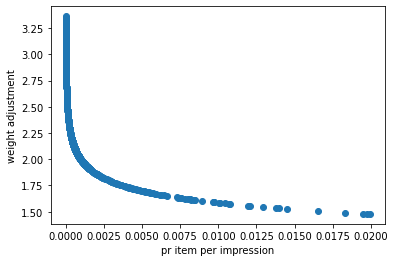

In [17]:
hyp_dat_ac = hyp_sub_sim.groupby('action').action.count()
pr_item = hyp_dat_ac / hyp_sub_sim.shape[0]
weights = 1/(pr_item**0.1)
weight_df = weights.to_frame().rename(columns={'action':'weight'})
ys = weights.values
plt.scatter(pr_item, ys)
plt.xlabel('pr item per impression')
plt.ylabel('weight adjustment')

In [18]:
# define hyp configuration as operation on the hyp dict:
rec_hyp_points = [{'n_hidden_layers':1, 'n_nodes':[500]},
                  {'n_hidden_layers':1, 'n_nodes':[1000]},
                  {'n_hidden_layers':1, 'n_nodes':[2000]},
                  {'n_hidden_layers':2, 'n_nodes':[500,100]},
                  {'n_hidden_layers':2, 'n_nodes':[500,500]},
                  {'n_hidden_layers':2, 'n_nodes':[1000,100]},
                  {'n_hidden_layers':2, 'n_nodes':[1000,500]},
                  {'n_hidden_layers':2, 'n_nodes':[2000,500]},
                  {'popularity_alpha':0.05, 'n_hidden_layers':1, 'n_nodes':[1000]},
                  {'popularity_alpha':0.1, 'n_hidden_layers':1, 'n_nodes':[1000]},
                  {'popularity_alpha':0.2, 'n_hidden_layers':1, 'n_nodes':[1000]}]

# define settings global to all experiments in hyp selection:
rec_hyp_global =  {'dropout_rate': 0.15, 
                      'hidden_activation': 'relu',
                      'max_epoch': 1,
                      'min_delta': 0.01, 
                      'batch_size':2048,
                      'train_ips': False,
                       'popularity_alpha':0
                    }

def train_hyp_rec(dat, stg, hyp, hyp_points, global_hyp, seed=84):
    np.random.seed(seed)
    train_rows = (dat['acnt.test_cell_nbr']==cells['train'])
    rec_train = dat[train_rows].sample(n=1000000)
    print('n train points', rec_train.shape[0])
    
    retval = [] # of form (model, all_hyp, delta_hyp)
    
    # define action popularity:
    dat_ac = dat.groupby('action').action.count()
    pr_item = dat_ac / dat.shape[0]
    weight_df = pr_item.to_frame().rename(columns={'action':'pr_item'})
    
    for hp in hyp_points:
        # update local copy of hyp:
        local_hyp = hyp.copy()
        print('updating with hp',hp)
        local_hyp.update(global_hyp)
        local_hyp.update(hp)
        print('training with hyp',local_hyp)
        
        # define weights:
        pop_alpha = local_hyp['popularity_alpha']
        if  pop_alpha > 0:
            weight_df['weight'] = 1/(weight_df.pr_item.values**pop_alpha)
            weights = rec_train.merge(weight_df, how='inner', on='action').weight
            print('weights shape',weights.shape)
        else:
            weights = np.ones(rec_train.shape[0])

        
        # define which cells to train on
        rec_cells = SETTINGS.simulation_components['rec_model_cell_nbr']
        NR = len(rec_cells)
        
        # train model
        rec_model = sim_models.RecModel(stg['NI'], stg['NI'], local_hyp)
        rec_model.fit(rec_train, stg['NI'], W_=weights[:,np.newaxis])

        retval.append((rec_model, local_hyp, hp))
    
    return retval

rec_models = train_hyp_rec(hyp_sub_sim, stg, SETTINGS.hyp['rec_model_hyp'], rec_hyp_points, rec_hyp_global)

n train points 1000000
updating with hp {'n_hidden_layers': 1, 'n_nodes': [500]}
training with hyp {'dropout_rate': 0.15, 'n_hidden_layers': 1, 'n_nodes': [500], 'hidden_activation': 'relu', 'max_epoch': 1, 'min_delta': 0.01, 'batch_size': 2048, 'train_ips': False, 'time_slots_per_day': 1.0, 'popularity_alpha': 0}
	 decoding state:
stats of sparse matrix 0 999999 0 919 1000000 920
	 one-hot encoding actions:


/apps/python3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1839: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


489/489 [==============================] - 19s 38ms/step - loss: 6.8220 - accuracy: 0.0070
updating with hp {'n_hidden_layers': 1, 'n_nodes': [1000]}
training with hyp {'dropout_rate': 0.15, 'n_hidden_layers': 1, 'n_nodes': [1000], 'hidden_activation': 'relu', 'max_epoch': 1, 'min_delta': 0.01, 'batch_size': 2048, 'train_ips': False, 'time_slots_per_day': 1.0, 'popularity_alpha': 0}
	 decoding state:
stats of sparse matrix 0 999999 0 919 1000000 920
	 one-hot encoding actions:
489/489 [==============================] - 28s 56ms/step - loss: 6.8215 - accuracy: 0.0076
updating with hp {'n_hidden_layers': 1, 'n_nodes': [2000]}
training with hyp {'dropout_rate': 0.15, 'n_hidden_layers': 1, 'n_nodes': [2000], 'hidden_activation': 'relu', 'max_epoch': 1, 'min_delta': 0.01, 'batch_size': 2048, 'train_ips': False, 'time_slots_per_day': 1.0, 'popularity_alpha': 0}
	 decoding state:
stats of sparse matrix 0 999999 0 919 1000000 920
	 one-hot encoding actions:
489/489 [===========================

/apps/python3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1839: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


489/489 [==============================] - 28s 57ms/step - loss: 9.0899 - accuracy: 0.0083
updating with hp {'popularity_alpha': 0.1, 'n_hidden_layers': 1, 'n_nodes': [1000]}
training with hyp {'dropout_rate': 0.15, 'n_hidden_layers': 1, 'n_nodes': [1000], 'hidden_activation': 'relu', 'max_epoch': 1, 'min_delta': 0.01, 'batch_size': 2048, 'train_ips': False, 'time_slots_per_day': 1.0, 'popularity_alpha': 0.1}
weights shape (1000000,)
	 decoding state:
stats of sparse matrix 0 999999 0 919 1000000 920
	 one-hot encoding actions:


/apps/python3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1839: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


489/489 [==============================] - 28s 57ms/step - loss: 12.1676 - accuracy: 0.0109
updating with hp {'popularity_alpha': 0.2, 'n_hidden_layers': 1, 'n_nodes': [1000]}
training with hyp {'dropout_rate': 0.15, 'n_hidden_layers': 1, 'n_nodes': [1000], 'hidden_activation': 'relu', 'max_epoch': 1, 'min_delta': 0.01, 'batch_size': 2048, 'train_ips': False, 'time_slots_per_day': 1.0, 'popularity_alpha': 0.2}
weights shape (1000000,)
	 decoding state:
stats of sparse matrix 0 999999 0 919 1000000 920
	 one-hot encoding actions:


/apps/python3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1839: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


489/489 [==============================] - 28s 57ms/step - loss: 22.0964 - accuracy: 0.0121


In [19]:
def save_hyp_rec_models(rec_models):
    # define file format based on delta hyp:
    hyp_ext = lambda delta_hyp: '_'.join([str(k)+'-'+str(v) for k,v in delta_hyp.items()])
    
    model_stem = join(paths.dat, SETTINGS.filepaths['rec_model_t_test'])
    model_stem_dir = join(paths.dat, 'rec_hyp_select')
    !mkdir {model_stem_dir}
    
    for (m,h,dh) in rec_models:
        target_path = join(model_stem_dir, 'rec_model_' + hyp_ext(dh))
        print('saving to target path',target_path)
        m.save(target_path)
    print('done.')
    
save_hyp_rec_models(rec_models)

saving to target path /root/notebooks/accordion/dat/rec_hyp_select/rec_model_n_hidden_layers-1_n_nodes-[500]
INFO:tensorflow:Assets written to: /root/notebooks/accordion/dat/rec_hyp_select/rec_model_n_hidden_layers-1_n_nodes-[500]/assets
saving to target path /root/notebooks/accordion/dat/rec_hyp_select/rec_model_n_hidden_layers-1_n_nodes-[1000]
INFO:tensorflow:Assets written to: /root/notebooks/accordion/dat/rec_hyp_select/rec_model_n_hidden_layers-1_n_nodes-[1000]/assets
saving to target path /root/notebooks/accordion/dat/rec_hyp_select/rec_model_n_hidden_layers-1_n_nodes-[2000]
INFO:tensorflow:Assets written to: /root/notebooks/accordion/dat/rec_hyp_select/rec_model_n_hidden_layers-1_n_nodes-[2000]/assets
saving to target path /root/notebooks/accordion/dat/rec_hyp_select/rec_model_n_hidden_layers-2_n_nodes-[500, 100]
INFO:tensorflow:Assets written to: /root/notebooks/accordion/dat/rec_hyp_select/rec_model_n_hidden_layers-2_n_nodes-[500, 100]/assets
saving to target path /root/notebo

In [70]:
def eval_hyp_rec_models(dat, rec_models, stg, seed=78):
    np.random.seed(seed)
    validation_rows = (dat['acnt.test_cell_nbr']==cells['test'])
    rec_val = dat[validation_rows].sample(n=500000,replace=False)
    print('n rows in validation',rec_val.shape[0], 'n positive', rec_val[rec_val.reward>0].shape[0])
    
    retval = [] # of form (rec_model, all_hyp, delta_hyp, val_loss)
    
    is_feature_processed = False
    for i,(m,h,dh) in enumerate(list(rec_models)):    
        if not(is_feature_processed):
            Sv, Av = m.process_features(rec_val, stg['NI'])
            S = Sv.todense()
            A = Av.todense()
            is_feature_processed = True
        loss,acc = m._model.evaluate(S, A)
        print('delta_hyp',dh,'loss',loss)
        retval.append((m,h,dh,loss))
        
    return retval
        
rec_models_loss = eval_hyp_rec_models(hyp_sub_sim, rec_models, stg)

loaded sim_models


In [23]:
rec_models_loss

[(<simtrain.sim_models.RecModel at 0x7f24ccc55fd0>,
  {'dropout_rate': 0.15,
   'n_hidden_layers': 1,
   'n_nodes': [500],
   'hidden_activation': 'relu',
   'max_epoch': 1,
   'min_delta': 0.01,
   'batch_size': 2048,
   'train_ips': False,
   'time_slots_per_day': 1.0,
   'popularity_alpha': 0},
  {'n_hidden_layers': 1, 'n_nodes': [500]},
  6.816145356231689),
 (<simtrain.sim_models.RecModel at 0x7f24c7f18d50>,
  {'dropout_rate': 0.15,
   'n_hidden_layers': 1,
   'n_nodes': [1000],
   'hidden_activation': 'relu',
   'max_epoch': 1,
   'min_delta': 0.01,
   'batch_size': 2048,
   'train_ips': False,
   'time_slots_per_day': 1.0,
   'popularity_alpha': 0},
  {'n_hidden_layers': 1, 'n_nodes': [1000]},
  6.814847313171387),
 (<simtrain.sim_models.RecModel at 0x7f24c538c690>,
  {'dropout_rate': 0.15,
   'n_hidden_layers': 1,
   'n_nodes': [2000],
   'hidden_activation': 'relu',
   'max_epoch': 1,
   'min_delta': 0.01,
   'batch_size': 2048,
   'train_ips': False,
   'time_slots_per_day': 

In [22]:
def save_hyp_rec_models_loss(rec_models_loss):
    # define file format based on delta hyp:
    hyp_ext = lambda delta_hyp: '_'.join([str(k)+'-'+str(v) for k,v in delta_hyp.items()])
    
    model_stem = join(paths.dat, SETTINGS.filepaths['rec_model_t_test'])
    model_stem_dir = join(paths.dat, 'rec_hyp_select')
    !mkdir {model_stem_dir}
    
    # build results dataframe for easy access:
    results_df = pd.DataFrame(columns=['delta_hyp', 'loss'])
    
    for (m,h,dh,loss) in rec_models_loss:
        target_path = join(model_stem_dir, 'rec_model_' + hyp_ext(dh))
        print('saving to target path',target_path)
        m.save(target_path)
        results_df = results_df.append({'delta_hyp':hyp_ext(dh), 'loss':loss}, ignore_index=True)
    print('done.')
    
    # save results object containing losses and hyps:
    results_df.to_csv(join(model_stem_dir, 'results.csv'))
        
save_hyp_rec_models_loss(rec_models_loss)

mkdir: cannot create directory ‘/root/notebooks/accordion/dat/rec_hyp_select’: File exists
saving to target path /root/notebooks/accordion/dat/rec_hyp_select/rec_model_n_hidden_layers-1_n_nodes-[500]
INFO:tensorflow:Assets written to: /root/notebooks/accordion/dat/rec_hyp_select/rec_model_n_hidden_layers-1_n_nodes-[500]/assets
saving to target path /root/notebooks/accordion/dat/rec_hyp_select/rec_model_n_hidden_layers-1_n_nodes-[1000]
INFO:tensorflow:Assets written to: /root/notebooks/accordion/dat/rec_hyp_select/rec_model_n_hidden_layers-1_n_nodes-[1000]/assets
saving to target path /root/notebooks/accordion/dat/rec_hyp_select/rec_model_n_hidden_layers-1_n_nodes-[2000]
INFO:tensorflow:Assets written to: /root/notebooks/accordion/dat/rec_hyp_select/rec_model_n_hidden_layers-1_n_nodes-[2000]/assets
saving to target path /root/notebooks/accordion/dat/rec_hyp_select/rec_model_n_hidden_layers-2_n_nodes-[500, 100]
INFO:tensorflow:Assets written to: /root/notebooks/accordion/dat/rec_hyp_sele

### conclusion
optimal hyperparameters are (n_layers = 1, n_nodes = 2000, alpha = 0.2)

finally: train on full dataset with optimal hyperparameters

In [24]:
opt_rec_hyp = SETTINGS.hyp['rec_model_hyp'].copy()
opt_rec_hyp.update({'popularity_alpha':0.2, 'n_hidden_layers':1, 'n_nodes':[2000], 'max_epoch':1})
opt_rec_hyp

{'dropout_rate': 0.15,
 'n_hidden_layers': 1,
 'n_nodes': [2000],
 'hidden_activation': 'relu',
 'max_epoch': 1,
 'min_delta': 0.01,
 'batch_size': 2048,
 'train_ips': False,
 'time_slots_per_day': 1.0,
 'popularity_alpha': 0.2}

In [26]:
# define which cells to train on
np.random.seed(100)
rec_cells = SETTINGS.simulation_components['rec_model_cell_nbr']
NR = len(rec_cells)
rec_model = sim_models.RecModel(stg['NI'], stg['NI'], opt_rec_hyp)
train_rows = (all_dat['acnt.test_cell_nbr']==cells['train'])
rec_train = all_dat[train_rows]

# define weights
train_ac = rec_train.groupby('action').action.count()
pr_item = train_ac / rec_train.shape[0]
weight_df = pr_item.to_frame().rename(columns={'action':'pr_item'})

pop_alpha = opt_rec_hyp['popularity_alpha']
print('pop alpha',pop_alpha)
if pop_alpha > 0:
    weight_df['weight'] = 1/(weight_df.pr_item.values**pop_alpha)
    weights = rec_train.merge(weight_df, how='inner', on='action').weight
    print('weights shape',weights.shape)
else:
    weights = np.ones(rec_train.shape[0])

print('n positive interactions in train',rec_train.reward.sum())
rec_model.fit(rec_train, stg['NI'], W_=weights[:,np.newaxis])
rec_model.save(join(paths.dat, 'opt_rec_model.h5'))

pop alpha 0.2
weights shape (8594958,)
n positive interactions in train 21271.0
	 decoding state:
stats of sparse matrix 1007 8594957 0 919 8594958 920
	 one-hot encoding actions:


/apps/python3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1839: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


4197/4197 [==============================] - 399s 95ms/step - loss: 21.8730 - accuracy: 0.0181


### User model hyp selection

hyperparameters to select over:
+ n_nodes per first layer = [200, 1000, 5000, 10000]
+ n_nodes per second layer = [0, 200, 1000, 5000]
+ alpha for popularity attenuation = [0., 0.1, 0.3, 0.5]

strategy:
+ select architecture, pick one that minimizes loss on validation data
+ then select alpha based on min loss on validation data

In [27]:
# define hyp configuration as operation on the hyp dict:
usr_hyp_points = [{'n_hidden_layers':1, 'n_nodes':[200]},
                  {'n_hidden_layers':1, 'n_nodes':[1000]},
                  {'n_hidden_layers':1, 'n_nodes':[5000]},
                  {'n_hidden_layers':1, 'n_nodes':[10000]},
                  {'n_hidden_layers':1, 'n_nodes':[5000,200]},
                  {'n_hidden_layers':1, 'n_nodes':[5000,1000]},
                  {'n_hidden_layers':1, 'n_nodes':[5000,5000]},
                  {'popularity_alpha':0.1, 'n_hidden_layers':1, 'n_nodes':[5000]},
                  {'popularity_alpha':0.3, 'n_hidden_layers':1, 'n_nodes':[5000]},
                  {'popularity_alpha':0.5, 'n_hidden_layers':1, 'n_nodes':[5000]}]

# define settings global to all experiments in hyp selection:
usr_hyp_global =  {'dropout_rate': 0.15,
                       'n_hidden_layers': 1, 
                       'n_nodes': [500], 
                       'hidden_activation': 'relu',
                       'max_epoch': 5,
                       'min_delta': 0.001,
                       'batch_size': 2048, 
                       'train_ips': False,
                       'popularity_alpha':0
                    }


def train_hyp_usr(dat, stg, hyp, hyp_points, global_hyp, seed=84):
    np.random.seed(seed)
    train_rows = ((dat['acnt.test_cell_nbr']==cells['train']) & (dat.reward > 0))
    usr_train = dat[train_rows]
    print('n train points', usr_train.shape[0])
    
    retval = [] # of form (model, all_hyp, delta_hyp)
    
    # define action-reward popularity:
    dat_ac = usr_train.groupby('action').action.count()
    pr_item = dat_ac / usr_train.shape[0]
    weight_df = pr_item.to_frame().rename(columns={'action':'pr_item'})
    
    for hp in hyp_points:
        # update local copy of hyp:
        local_hyp = hyp.copy()
        print('updating with hp',hp)
        local_hyp.update(global_hyp)
        local_hyp.update(hp)
        print('training with hyp',local_hyp)
        
        # define weights:
        pop_alpha = local_hyp['popularity_alpha']
        if  pop_alpha > 0:
            weight_df['weight'] = 1/(weight_df.pr_item.values**pop_alpha)
            weights = usr_train.merge(weight_df, how='inner', on='action').weight.values
            print('weights shape',weights.shape)
        else:
            weights = np.ones(rec_train.shape[0])
        
        # train model
        usr_model = sim_models.UserModel(stg['NI'], stg['NI'], local_hyp)
        usr_model.fit(usr_train, stg['NI'], stg['NI'], W_=weights[:,np.newaxis], ips=False)

        retval.append((usr_model, local_hyp, hp))
    
    return retval

usr_models = train_hyp_usr(all_dat, stg, SETTINGS.hyp['user_model_hyp'], usr_hyp_points, usr_hyp_global)

n train points 21271
updating with hp {'n_hidden_layers': 1, 'n_nodes': [200]}
training with hyp {'dropout_rate': 0.15, 'n_hidden_layers': 1, 'n_nodes': [200], 'hidden_activation': 'relu', 'max_epoch': 5, 'min_delta': 0.001, 'batch_size': 2048, 'train_ips': False, 'popularity_alpha': 0}
fitting user model:
stats of sparse matrix 1 21270 0 919 21271 920
train ips = False
Epoch 1/5
11/11 [==============================] - 1s 23ms/step - loss: 6.8240 - accuracy: 0.0058
Epoch 2/5
11/11 [==============================] - 0s 25ms/step - loss: 6.8234 - accuracy: 0.0182
updating with hp {'n_hidden_layers': 1, 'n_nodes': [1000]}
training with hyp {'dropout_rate': 0.15, 'n_hidden_layers': 1, 'n_nodes': [1000], 'hidden_activation': 'relu', 'max_epoch': 5, 'min_delta': 0.001, 'batch_size': 2048, 'train_ips': False, 'popularity_alpha': 0}
fitting user model:
stats of sparse matrix 1 21270 0 919 21271 920
train ips = False
Epoch 1/5
11/11 [==============================] - 1s 54ms/step - loss: 6.824

In [28]:
def save_hyp_usr_models(models):
    # define file format based on delta hyp:
    hyp_ext = lambda delta_hyp: '_'.join([str(k)+'-'+str(v) for k,v in delta_hyp.items()])
    
    model_stem = join(paths.dat, SETTINGS.filepaths['user_model_test'])
    model_stem_dir = join(paths.dat, 'usr_hyp_select')
    !mkdir {model_stem_dir}
    
    for (m,h,dh) in models:
        target_path = join(model_stem_dir, 'usr_model_' + hyp_ext(dh))
        print('saving to target path',target_path)
        m.save(target_path)
    print('done.')
    
save_hyp_usr_models(usr_models)

saving to target path /root/notebooks/accordion/dat/usr_hyp_select/usr_model_n_hidden_layers-1_n_nodes-[200]
INFO:tensorflow:Assets written to: /root/notebooks/accordion/dat/usr_hyp_select/usr_model_n_hidden_layers-1_n_nodes-[200]/assets
saving to target path /root/notebooks/accordion/dat/usr_hyp_select/usr_model_n_hidden_layers-1_n_nodes-[1000]
INFO:tensorflow:Assets written to: /root/notebooks/accordion/dat/usr_hyp_select/usr_model_n_hidden_layers-1_n_nodes-[1000]/assets
saving to target path /root/notebooks/accordion/dat/usr_hyp_select/usr_model_n_hidden_layers-1_n_nodes-[5000]
INFO:tensorflow:Assets written to: /root/notebooks/accordion/dat/usr_hyp_select/usr_model_n_hidden_layers-1_n_nodes-[5000]/assets
saving to target path /root/notebooks/accordion/dat/usr_hyp_select/usr_model_n_hidden_layers-1_n_nodes-[10000]
INFO:tensorflow:Assets written to: /root/notebooks/accordion/dat/usr_hyp_select/usr_model_n_hidden_layers-1_n_nodes-[10000]/assets
saving to target path /root/notebooks/ac

In [29]:
def eval_hyp_usr_models(dat, models, stg, seed=78):
    np.random.seed(seed)
    validation_rows = ((dat['acnt.test_cell_nbr']==cells['valid']) & (dat.reward>0))
    usr_val = dat[validation_rows]
    print('n rows in validation',usr_val.shape[0])
    
    retval = [] # of form (rec_model, all_hyp, delta_hyp, val_loss)
    
    is_feature_processed = False
    for i,(m,h,dh) in enumerate(list(models)):    
        if not(is_feature_processed):
            Sv, Av, _ = m.process_features(usr_val, stg['NI'])
            S = Sv.todense()
            A = Av.todense()
            is_feature_processed = True
        loss,acc = m._model.evaluate(S, A)
        print('delta_hyp',dh,'loss',loss)
        retval.append((m,h,dh,loss))
        
    return retval
        
usr_models_loss = eval_hyp_usr_models(all_dat, usr_models, stg)

n rows in validation 9115
stats of sparse matrix 1 9114 0 919 9115 920
285/285 [==============================] - 1s 2ms/step - loss: 6.8231 - accuracy: 0.0199
delta_hyp {'n_hidden_layers': 1, 'n_nodes': [200]} loss 6.82314491005174
285/285 [==============================] - 1s 3ms/step - loss: 6.8230 - accuracy: 0.0138
delta_hyp {'n_hidden_layers': 1, 'n_nodes': [1000]} loss 6.8229789363507445
285/285 [==============================] - 2s 5ms/step - loss: 6.8229 - accuracy: 0.0285
delta_hyp {'n_hidden_layers': 1, 'n_nodes': [5000]} loss 6.822870035375531
285/285 [==============================] - 2s 8ms/step - loss: 6.8228 - accuracy: 0.0354
delta_hyp {'n_hidden_layers': 1, 'n_nodes': [10000]} loss 6.822810058677452
285/285 [==============================] - 2s 5ms/step - loss: 6.8228 - accuracy: 0.0337
delta_hyp {'n_hidden_layers': 1, 'n_nodes': [5000, 200]} loss 6.822763762733012
285/285 [==============================] - 2s 5ms/step - loss: 6.8229 - accuracy: 0.0413
delta_hyp {'n_h

In [30]:
usr_models_loss

[(<simtrain.sim_models.UserModel at 0x7f282982b150>,
  {'dropout_rate': 0.15,
   'n_hidden_layers': 1,
   'n_nodes': [200],
   'hidden_activation': 'relu',
   'max_epoch': 5,
   'min_delta': 0.001,
   'batch_size': 2048,
   'train_ips': False,
   'popularity_alpha': 0},
  {'n_hidden_layers': 1, 'n_nodes': [200]},
  6.82314491005174),
 (<simtrain.sim_models.UserModel at 0x7f2829a79990>,
  {'dropout_rate': 0.15,
   'n_hidden_layers': 1,
   'n_nodes': [1000],
   'hidden_activation': 'relu',
   'max_epoch': 5,
   'min_delta': 0.001,
   'batch_size': 2048,
   'train_ips': False,
   'popularity_alpha': 0},
  {'n_hidden_layers': 1, 'n_nodes': [1000]},
  6.8229789363507445),
 (<simtrain.sim_models.UserModel at 0x7f2829c6d250>,
  {'dropout_rate': 0.15,
   'n_hidden_layers': 1,
   'n_nodes': [5000],
   'hidden_activation': 'relu',
   'max_epoch': 5,
   'min_delta': 0.001,
   'batch_size': 2048,
   'train_ips': False,
   'popularity_alpha': 0},
  {'n_hidden_layers': 1, 'n_nodes': [5000]},
  6.822

### conclusion
optimal user model hyp are (n_layers = 1, n_nodes = [10000], pop_alpha = 0.5)

finally: train on full dataset with optimal hyperparameters

In [31]:
# save results to file:
def save_results(rs, relative_dir):
    model_stem = join(paths.dat, SETTINGS.filepaths['user_model_test'])
    model_stem_dir = join(paths.dat, relative_dir)
    !mkdir {model_stem_dir}
    hyp_ext = lambda delta_hyp: '_'.join([str(k)+'-'+str(v) for k,v in delta_hyp.items()])
    
    results = pd.DataFrame(columns=['delta_hyp', 'loss'])
    
    for i,(m,h,dh,l) in enumerate(rs):    
        results = results.append({'delta_hyp':hyp_ext(dh), 'loss':l}, ignore_index=True)
    
    results.to_csv(join(model_stem_dir, 'hyp_results.csv'))
    print('saved:\n',results)
        

In [32]:
save_results(usr_models_loss, 'usr_hyp_select')
save_results(rec_models_loss, 'rec_hyp_select')

mkdir: cannot create directory ‘/root/notebooks/accordion/dat/usr_hyp_select’: File exists
saved:
                                            delta_hyp      loss
0                    n_hidden_layers-1_n_nodes-[200]  6.823145
1                   n_hidden_layers-1_n_nodes-[1000]  6.822979
2                   n_hidden_layers-1_n_nodes-[5000]  6.822870
3                  n_hidden_layers-1_n_nodes-[10000]  6.822810
4              n_hidden_layers-1_n_nodes-[5000, 200]  6.822764
5             n_hidden_layers-1_n_nodes-[5000, 1000]  6.822887
6             n_hidden_layers-1_n_nodes-[5000, 5000]  6.822436
7  popularity_alpha-0.1_n_hidden_layers-1_n_nodes...  6.818140
8  popularity_alpha-0.3_n_hidden_layers-1_n_nodes...  6.813070
9  popularity_alpha-0.5_n_hidden_layers-1_n_nodes...  6.791835
mkdir: cannot create directory ‘/root/notebooks/accordion/dat/rec_hyp_select’: File exists
saved:
                                             delta_hyp      loss
0                     n_hidden_layers-1_n_nod

In [33]:
opt_usr_hyp = SETTINGS.hyp['user_model_hyp'].copy()
opt_usr_hyp.update(usr_models_loss[-1][2])
opt_usr_hyp

{'dropout_rate': 0.15,
 'n_hidden_layers': 1,
 'n_nodes': [5000],
 'hidden_activation': 'relu',
 'max_epoch': 10,
 'min_delta': 0.001,
 'batch_size': 2048,
 'train_ips': False,
 'popularity_alpha': 0.5}

In [34]:
user_model = usr_models_loss[-1][0]
user_model

In [35]:
user_model.save(join(paths.dat, 'opt_user_model.h5'))

## Train Visit Model

In [67]:
# train visit model:
# use fewer cores here because more memory is needed
os.environ['NUMEXPR_MAX_THREADS'] = str(int(int(SETTINGS.NUMEXPR_MAX_THREADS)/2))
sub_sim_stg = process_dat.get_settings(sub_sim)

def fit_visit(dat, stg, hyp, parallel=True):
    # fit activity-based visit model:
    visit_model = sim_models.VisitModel(stg['NI'],stg['NU'],hyp)
    visit_dat, n_impressions_by_visit = sim_models.preprocess_visit_dat(dat, SETTINGS.simulation_components['visit_model_cell_nbr'])
    visit_model.fit(visit_dat, n_impressions_by_visit, hyp, stg, parallel=parallel)
    #visit_model.save(paths.dat + SETTINGS.filepaths['visit_model_test-%s' % ab_test_id])
    return visit_model

train_dat = all_dat[all_dat['acnt.test_cell_nbr']==cells['train']]
train_stg = process_dat.get_settings(train_dat)
visit_model = fit_visit(train_dat, train_stg, SETTINGS.hyp['visit_model_hyp'])

loaded sim_models
history_end_indx 5526
[<KerasTensor: shape=(None, 921) dtype=float64 (created by layer 'tf.__operators__.getitem_237')>, <KerasTensor: shape=(None, 921) dtype=float64 (created by layer 'tf.__operators__.getitem_238')>, <KerasTensor: shape=(None, 921) dtype=float64 (created by layer 'tf.__operators__.getitem_239')>, <KerasTensor: shape=(None, 921) dtype=float64 (created by layer 'tf.__operators__.getitem_240')>, <KerasTensor: shape=(None, 921) dtype=float64 (created by layer 'tf.__operators__.getitem_241')>]
visit model: num. unique visits in training data 45779
fitting visit model:
parallelizing across num. partitions 8
X (45779, 5526)
X_reg (45779, 5526)
X.shape,type(X) (45779, 5526) <class 'scipy.sparse.csr.csr_matrix'>
Epoch 1/100
358/358 [==============================] - 5s 11ms/step - loss: -1.3958 - accuracy: 1.0000 - count_error: 0.3136 - val_loss: -1.6216 - val_accuracy: 1.0000 - val_count_error: 0.0775
Epoch 2/100
358/358 [==============================] - 4

In [68]:
visit_model.save(join(paths.dat, SETTINGS.filepaths['visit_model_test-%s' % ab_test_id] + '.big'))

In [50]:
SETTINGS.hyp['visit_model_hyp']

{'visit_loss_method': 'event_sample',
 'lambda_grid_factor': 0.01,
 'n_samples_per_user': 100,
 'user_point_sample_factor': 1.0,
 'time_sample_size': 100,
 'parallel_process_features': True,
 'visit_sample_grid_size': 0.5,
 'fit_log_granular': False,
 'log_history_path': 'dat/log/model_history_log.csv',
 'window_size': 5,
 'batch_size': 128,
 'max_epoch': 100,
 'patience': 0,
 'min_delta': 0.0001,
 'train_val_split': 1.0,
 'time_model': {'n_hidden_layers': 1,
  'n_nodes': [100],
  'hidden_activation': 'relu',
  'dropout_rate': 0.2},
 'state_model': {'n_hidden_layers': 1,
  'n_nodes': [20],
  'hidden_activation': 'relu',
  'dropout_rate': 0.5,
  'dropout_positives': True},
 'binary_classifier': {'lookahead_hours': 24,
  'time_embed_dim': 10,
  'n_hidden_layers': 2,
  'n_nodes': [500, 100],
  'hidden_activation': 'relu',
  'dropout_rate': 0.1}}

DescribeResult(nobs=10131, minmax=(0.0, 1.0), mean=0.002961208172934557, variance=0.0029527308741176678, skewness=18.294889177116367, kurtosis=332.7029700029699)
total imp for user 10131
total visits for user 30
total streams for user 30.0
ave streams per day for user 0.42869566800594094
ave imp per day for user 144.77052708560626
ave imp per visit for user 337.7
num. streamed titles at t=0 0.0
num. streamed titles at final t 13.0


(array([[-0.91414608,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [-0.91355067,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [-0.91295526,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 1.08464747,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 1.08524289,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 1.0858383 ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]]),
 array([0.00000000e+00, 2.08333333e-02, 4.16666667e-02, ...,
        6.99375000e+01, 6.99583333e+01, 6.99791667e+01]))

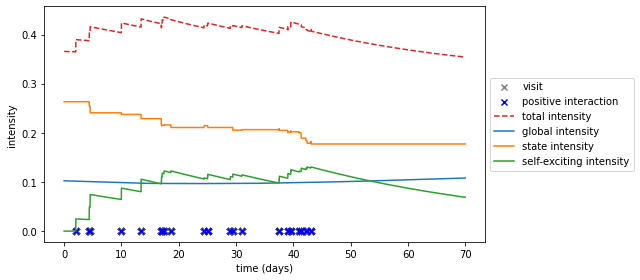

In [69]:
explore_models.plot_rnd_user_visits(2, (1,1,1,1), train_dat, visit_model, train_stg, SETTINGS.hyp,
                         None)